In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
file_path = 'train.csv'
data = pd.read_csv(file_path)

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


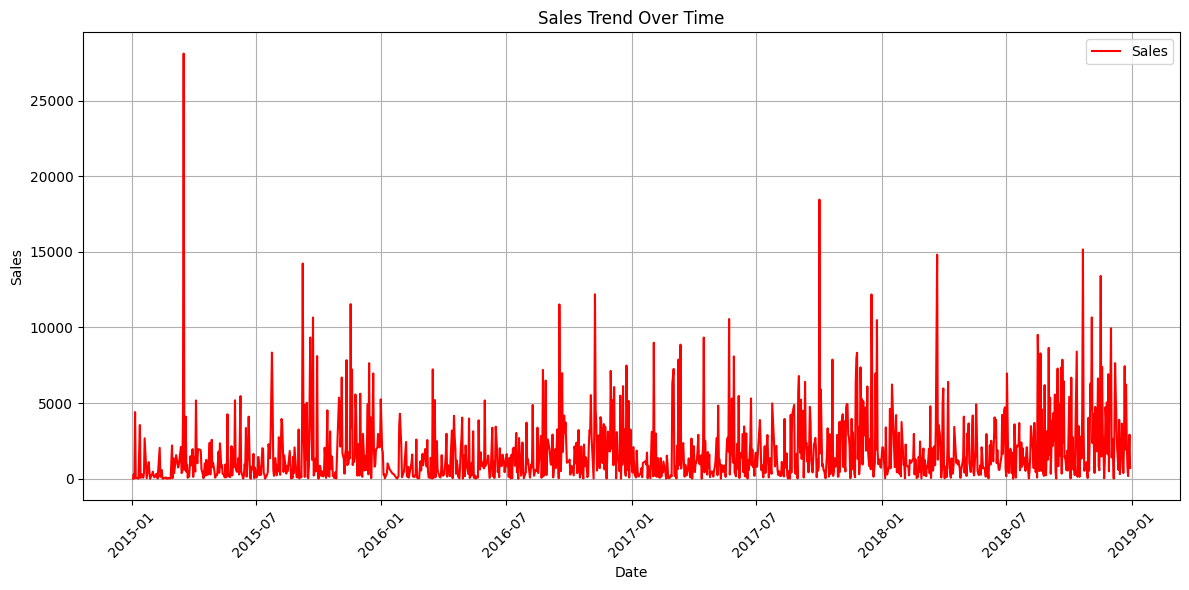

In [4]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

sales_by_date = data.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(sales_by_date['Order Date'], sales_by_date['Sales'], label='Sales', color='red')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
def create_lagged_features(data, lag=1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['Sales'].shift(i)
    return lagged_data

lag = 5  
sales_with_lags = create_lagged_features(data[['Order Date', 'Sales']], lag)

sales_with_lags = sales_with_lags.dropna()

In [6]:
X = sales_with_lags.drop(columns=['Order Date', 'Sales'])
y = sales_with_lags['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [9]:
import numpy as np
predictions_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

print(f"RMSE: {rmse_xgb:.2f}")

RMSE: 734.63


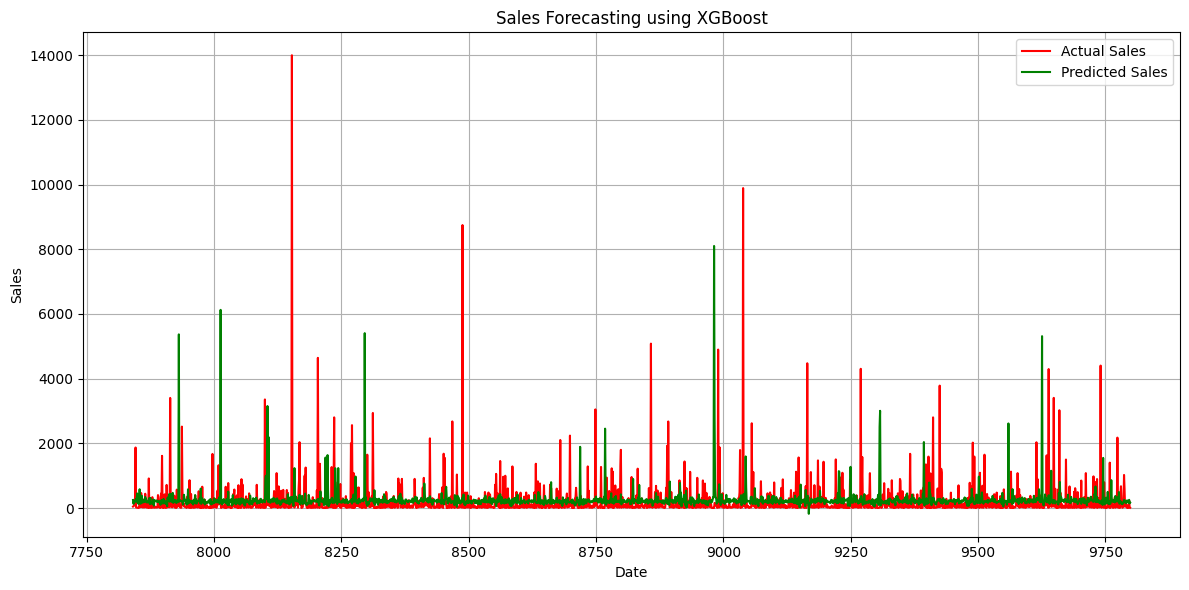

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='red')
plt.plot(y_test.index, predictions_xgb, label='Predicted Sales', color='green')
plt.title('Sales Forecasting using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()